## Capstone Project

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

In [3]:
!pip install -q findspark

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [5]:
import findspark
findspark.init()

In [6]:
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext()
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


#**Weather Dataset**

In [7]:
import time
import glob
import pandas as pd
import re 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import lit
from functools import reduce 
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model


In [8]:
start =time.time()

In [9]:
path = "/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/" # Path to my weather datasets in google drive(Accessible to UMBC group members)
files = glob.glob(path+"*") #Using glob module to return the fies in weather datasets 
print(files) # Printing all the food crop files path
print("No:of files in the directory : ",len(files)) # Checking no:of files in the list 

['/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Andhra Pradesh.xlsx', '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Maharashtra.xlsx', '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Madhya Pradesh.xlsx', '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Kerala.xlsx', '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Jharkhand.xlsx', '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Arunachal Pradesh.xlsx', '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Gujarat.xlsx', '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/West Bengal.xlsx', '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Haryana.xlsx', '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Assam.xlsx', '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Goa.xlsx', '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Chhattisgarh.xlsx', '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Himachal Pradesh.xlsx', '/content

In [10]:
xlsx_files  = glob.glob(path+"/*")# Storing the paths of all the excel files into a list 
xlsx_files # Printing all the excel files

['/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Andhra Pradesh.xlsx',
 '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Maharashtra.xlsx',
 '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Madhya Pradesh.xlsx',
 '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Kerala.xlsx',
 '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Jharkhand.xlsx',
 '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Arunachal Pradesh.xlsx',
 '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Gujarat.xlsx',
 '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/West Bengal.xlsx',
 '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Haryana.xlsx',
 '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Assam.xlsx',
 '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Goa.xlsx',
 '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Chhattisgarh.xlsx',
 '/content/drive/MyDrive/Capstone/Datasets/Weather Dataset/Himachal Pradesh.xlsx

In [11]:
len(xlsx_files)

29

In [12]:
df_samp1 = pd.read_excel(xlsx_files[0], header=None)  # Creating a sample dataframe from one of the excel files

In [13]:
df_samp1.dtypes

0     object
1     object
2     object
3     object
4     object
5     object
6     object
7     object
8     object
9     object
10    object
11    object
12    object
13    object
14    object
dtype: object

In [14]:
df_samp1 =df_samp1.astype('str')
sp_df_samp1 = sqlContext.createDataFrame(df_samp1)
sp_df_samp1 = sp_df_samp1.withColumn("id", monotonically_increasing_id())
sp_df_samp1.show(30)

+--------------------+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---+
|                   0|   1|    2|    3|    4|    5|    6|    7|    8|    9|   10|   11|   12|   13|   14| id|
+--------------------+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---+
|      -BEGIN HEADER-| nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  0|
|NASA/POWER CERES/...| nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  1|
|Dates (month/day/...| nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  2|
|Location: Latitud...| nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  3|
|Elevation from ME...| nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  4|
|Value for missing...| nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  nan|  5|
|      Par

In [15]:
sp_df_samp1.schema

StructType(List(StructField(0,StringType,true),StructField(1,StringType,true),StructField(2,StringType,true),StructField(3,StringType,true),StructField(4,StringType,true),StructField(5,StringType,true),StructField(6,StringType,true),StructField(7,StringType,true),StructField(8,StringType,true),StructField(9,StringType,true),StructField(10,StringType,true),StructField(11,StringType,true),StructField(12,StringType,true),StructField(13,StringType,true),StructField(14,StringType,true),StructField(id,LongType,false)))

In [16]:
sp_df_samp1 = sp_df_samp1.withColumn("STATE",lit(None))
schema1 = sp_df_samp1.schema

df_original = sqlContext.createDataFrame([],schema1) # Creating an empty dataframe
 
# explicit functions
def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)
for i in xlsx_files:
  pd_df_samp1 = pd.read_excel(i,header = None)
  pd_df_samp1 = pd_df_samp1.astype('str')
  df_samp1 = sqlContext.createDataFrame(pd_df_samp1)
  df_samp1 = df_samp1.withColumn("id", monotonically_increasing_id())
  new_col = df_samp1.collect()[20]
  df_samp1 = df_samp1.where(df_samp1.id>20) # deleting top 20 rows from our dataframe
  df_samp1 = df_samp1.withColumn("STATE", lit(i[57:-5])) # Adding values into "State" column 
  df_original = unionAll(*[df_original,df_samp1]) # Appending each individual dataframe into df_orginal
#df_original.reset_index(drop=True, inplace=True) # Resetting the index values 





In [17]:
print("No:of rows = ",df_original.count(),"No:of Columns =",len(df_original.columns))

No:of rows =  3480 No:of Columns = 17


In [18]:
  #df_samp1.toDF(*new_col)

In [19]:
new_list =[]
for i in new_col:
  new_list.append(i)
new_list[-1] = "ID"
new_list.append("STATE")
df_original = df_original.toDF(*new_list)

In [20]:
df_original.show()

+---------+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---+--------------+
|PARAMETER|YEAR|  JAN|  FEB|  MAR|  APR|  MAY|  JUN|  JUL|  AUG|  SEP|  OCT|  NOV|  DEC|  ANN| ID|         STATE|
+---------+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---+--------------+
|     QV2M|2011|13.24|13.85|14.22|16.78|17.15| 16.3|16.91|17.76|17.82|17.33| 15.2|14.16|15.93| 21|Andhra Pradesh|
|     QV2M|2012|13.43|12.45|15.14|16.78|16.48|15.75|17.21|17.21|17.88|16.97|15.62|14.53|15.81| 22|Andhra Pradesh|
|     QV2M|2013|13.67|13.55|14.34|16.97|17.09|17.21|17.09|18.07|18.62|18.49|16.05|12.94|16.17| 23|Andhra Pradesh|
|     QV2M|2014|13.37|   13|13.61|15.81|17.88|16.66|17.09|17.64|18.01|17.15|15.08|13.98|15.81| 24|Andhra Pradesh|
|     QV2M|2015|12.63|12.63|14.65|16.48|17.03|17.76|16.97|18.07|18.31|17.03|16.72|14.59|16.11| 25|Andhra Pradesh|
|     QV2M|2016|13.12|14.22|15.38|16.85|17.76|18.19|17.82|17.33|18.07|15.75|13.79|12.88|

In [21]:
list_parameters = df_original.select('PARAMETER').distinct().collect()

In [22]:
list_parameters

[Row(PARAMETER='T2MDEW'),
 Row(PARAMETER='GWETTOP'),
 Row(PARAMETER='T2M_MAX'),
 Row(PARAMETER='T2M_MIN'),
 Row(PARAMETER='QV2M'),
 Row(PARAMETER='WS2M_MAX'),
 Row(PARAMETER='GWETROOT'),
 Row(PARAMETER='PRECTOTCORR'),
 Row(PARAMETER='GWETPROF'),
 Row(PARAMETER='ALLSKY_SFC_PAR_TOT'),
 Row(PARAMETER='CLOUD_AMT'),
 Row(PARAMETER='WS2M_MIN')]

In [23]:
len(list_parameters) == 12

True

In [24]:
list_states = df_original.select('STATE').distinct().collect()

In [25]:
len(list_states) == 29

True

In [26]:
df_original.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_original.columns]).show()


+---------+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+-----+
|PARAMETER|YEAR|JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC|ANN| ID|STATE|
+---------+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+-----+
|        0|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|    0|
+---------+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+-----+



In [27]:
df_original.columns

['PARAMETER',
 'YEAR',
 'JAN',
 'FEB',
 'MAR',
 'APR',
 'MAY',
 'JUN',
 'JUL',
 'AUG',
 'SEP',
 'OCT',
 'NOV',
 'DEC',
 'ANN',
 'ID',
 'STATE']

In [28]:
#df_original.write.format("csv").save("/content/drive/MyDrive/Capstone/Datasets/Final_Datasets/Final_Wether_Dataset")

# **EDA of CROPS DATASET**

In [29]:
path = "/content/drive/MyDrive/Capstone/Datasets/Vegtables/" # Path to my vegetable dataset in google drive(Accessible to UMBC group members)
files = glob.glob(path+"*") #Using glob module to return the fies of 10 different perishable food crops 
print(files) # Printing all the food crop files path
print("No:of files in the directory : ",len(files)) # Checking no:of files in the list /

['/content/drive/MyDrive/Capstone/Datasets/Vegtables/Bitter Gourd', '/content/drive/MyDrive/Capstone/Datasets/Vegtables/Brinjal', '/content/drive/MyDrive/Capstone/Datasets/Vegtables/Cabbage', '/content/drive/MyDrive/Capstone/Datasets/Vegtables/Cauliflower', '/content/drive/MyDrive/Capstone/Datasets/Vegtables/Green Chillies', '/content/drive/MyDrive/Capstone/Datasets/Vegtables/Okra', '/content/drive/MyDrive/Capstone/Datasets/Vegtables/Onion', '/content/drive/MyDrive/Capstone/Datasets/Vegtables/Peas', '/content/drive/MyDrive/Capstone/Datasets/Vegtables/Tomato Hybrid', '/content/drive/MyDrive/Capstone/Datasets/Vegtables/Tomato Local']
No:of files in the directory :  10


In [30]:
xlsx_files= [] # Creating an empty list 
for i in range(0,10):
  file1 = glob.glob(files[i]+"/*")# Adding "/*" to the end of each folder path to retrieve all the files in that folder
  xlsx_files.append(file1) # Appending all the files retrieved from that folder into xlsx.files list 

In [31]:
for i in range(0,len(xlsx_files)):# Printing no:of excel files related to each individual food crop
  print(len(xlsx_files[i]))
xlsx_files # Pring all the excel files

11
11
11
11
11
11
11
11
11
11


[['/content/drive/MyDrive/Capstone/Datasets/Vegtables/Bitter Gourd/BG 2011.xls.xlsx',
  '/content/drive/MyDrive/Capstone/Datasets/Vegtables/Bitter Gourd/BG 2012.xlsx',
  '/content/drive/MyDrive/Capstone/Datasets/Vegtables/Bitter Gourd/Bg 2013.xls.xlsx',
  '/content/drive/MyDrive/Capstone/Datasets/Vegtables/Bitter Gourd/BG 2014.xls.xlsx',
  '/content/drive/MyDrive/Capstone/Datasets/Vegtables/Bitter Gourd/BG 2015.xls.xlsx',
  '/content/drive/MyDrive/Capstone/Datasets/Vegtables/Bitter Gourd/BG 2016.xls.xlsx',
  '/content/drive/MyDrive/Capstone/Datasets/Vegtables/Bitter Gourd/BG 2017.xls.xlsx',
  '/content/drive/MyDrive/Capstone/Datasets/Vegtables/Bitter Gourd/BG 2018.xls.xlsx',
  '/content/drive/MyDrive/Capstone/Datasets/Vegtables/Bitter Gourd/BG 2020.xls.xlsx',
  '/content/drive/MyDrive/Capstone/Datasets/Vegtables/Bitter Gourd/BG 2019.xls.xlsx',
  '/content/drive/MyDrive/Capstone/Datasets/Vegtables/Bitter Gourd/BG 2021.xls.xlsx'],
 ['/content/drive/MyDrive/Capstone/Datasets/Vegtables/Bri

In [32]:
df_samp11  = pd.read_excel(xlsx_files[0][0])

In [33]:
df_samp11 =df_samp11.astype('str')
sp_df_samp1 = sqlContext.createDataFrame(df_samp11)
schema2 = sp_df_samp1.schema

In [34]:
sp_df_samp1.show(30)

+-----------------------------------------------------+--------------------+----------------+-----------------+-------------+----------------+-----------------+-------------+----------------+-----------------+-------------+----------------+-----------------+-------------+----------------+-----------------+-------------+----------------+-----------------+-------------+----------------+-----------------+-------------+----------------+-----------------+-------------+----------------+-----------------+-------------+----------------+-----------------+-------------+----------------+-----------------+-------------+----------------+-----------------+-------------+
|Report Name : Monthwise Annual Price & Arrival Report|          Unnamed: 1|      Unnamed: 2|       Unnamed: 3|   Unnamed: 4|      Unnamed: 5|       Unnamed: 6|   Unnamed: 7|      Unnamed: 8|       Unnamed: 9|  Unnamed: 10|     Unnamed: 11|      Unnamed: 12|  Unnamed: 13|     Unnamed: 14|      Unnamed: 15|  Unnamed: 16|     Unnamed: 

In [35]:

list_row = [] # Creating an empty list for row values
list_col = [] # Creating an empty list for column values
list_states = [] # Creating an empty list for city names
for i in range(0,10): # value of "i" in range of no:of food crops
  list_row1 = []
  list_col1 = []
  for j in range(0,11): # value of "j" in range of no:of individual excel files in a pirticular food crop
    df2 = pd.read_excel(xlsx_files[i][j]) # Reading a pirticular food crop into a dataframe named df2
# Column name for city at which the crop is collected is "Unnamed: 1".
    for a in list(df2['Unnamed: 1']):  # For each cell value in "Unnamed:1" column
      if a not in list_states: # If it is not in "list_states" list
        list_states.append(a) # Append it to the list 
    list_row1.append(len(df2)) # Appending the value of no:of rows of that dataframe into a list named list_row1 
    list_col1.append(len(df2.columns))# Appending the value of no:of columns of that dataframe into a list named list_col1 
    
  list_row.append(list_row1) # Appending list of all the row lengths of individual files of a crop into a list
  list_col.append(list_col1)

In [36]:
list_row # Printing row lengths of all the individual files 

[[35, 35, 33, 33, 32, 32, 36, 35, 29, 34, 30],
 [25, 27, 29, 29, 29, 25, 28, 28, 29, 29, 28],
 [37, 36, 36, 37, 35, 34, 25, 25, 35, 25, 32],
 [32, 37, 37, 36, 36, 34, 35, 35, 35, 36, 35],
 [34, 34, 35, 37, 36, 37, 32, 35, 35, 36, 36],
 [36, 32, 36, 31, 35, 34, 36, 33, 36, 33, 35],
 [32, 37, 37, 38, 37, 37, 37, 37, 38, 36, 37],
 [33, 32, 31, 31, 31, 27, 32, 34, 32, 36, 35],
 [33, 35, 35, 38, 36, 36, 38, 35, 38, 36, 37],
 [24, 24, 26, 27, 29, 28, 30, 31, 25, 29, 29]]

In [37]:
# Printing the value of maximum number of rows of an excel file among all the files present 
# max1 = 0 
# for i in list_row:
#   max1 = max(max1,max(i))
# print(max1)

In [38]:
# listx =[1,2,3]
# b = max(listx)


In [39]:
list_col # Printing column lengths of all the individual files 

[[38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38],
 [38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38],
 [38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38],
 [38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38],
 [38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38],
 [38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38],
 [38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38],
 [38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38],
 [38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38],
 [38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38]]

In [40]:
# Conclusion:  All the datasets consists of equal number of columns that is 38

In [41]:
# List of all the unique states present in entire vegetebale datasets 
list_states = []
for i in range(0,10):
  for j in range(0,11):
    df3 = pd.read_excel(xlsx_files[i][j])
    for a in list(df3['Unnamed: 1']):
      if a not in list_states:
        list_states.append(a)

In [42]:
# List of all the city names
#list_states

In [43]:
len(list_states) # No:of cities present in all the excel files 

55

In [44]:
"""" Conclusion:
          1)There are 55 different city names 
          2)India consists of 28 states and 7 union teritories 
          3)So the data might be collected from different places in a single state in different years""" 

'" Conclusion:\n          1)There are 55 different city names \n          2)India consists of 28 states and 7 union teritories \n          3)So the data might be collected from different places in a single state in different years'

In [45]:
# Appending all the individual dataframes from each individual excel files into df_original dataframe  

df_original1 = sqlContext.createDataFrame([],schema2) # Creating an empty data frame 
for i in range(0,10): # value of "i" in range of no:of food crops
  for j in range(0,11): # value of "j" in range of no:of individual excel files in a pirticular food crop
    df_i = pd.read_excel(xlsx_files[i][j]) # Reading a pirticular food crop into a dataframe named df_i
    df_i = df_i.astype('str')
    df_samp1 = sqlContext.createDataFrame(df_i)
    df_original1 = unionAll(*[df_samp1,df_original1])
    

In [46]:
df_original1.show(30)

+-----------------------------------------------------+--------------------+----------------+-----------------+-------------+----------------+-----------------+-------------+----------------+-----------------+-------------+----------------+-----------------+-------------+----------------+-----------------+-------------+----------------+-----------------+-------------+----------------+-----------------+-------------+----------------+-----------------+-------------+----------------+-----------------+-------------+----------------+-----------------+-------------+----------------+-----------------+-------------+----------------+-----------------+-------------+
|Report Name : Monthwise Annual Price & Arrival Report|          Unnamed: 1|      Unnamed: 2|       Unnamed: 3|   Unnamed: 4|      Unnamed: 5|       Unnamed: 6|   Unnamed: 7|      Unnamed: 8|       Unnamed: 9|  Unnamed: 10|     Unnamed: 11|      Unnamed: 12|  Unnamed: 13|     Unnamed: 14|      Unnamed: 15|  Unnamed: 16|     Unnamed: 

## Modifying the combined dataset
  ### 1) Deleting unwanted rows
  ### 2) Deleting unwanted columns
  ### 3) Renaming the header values

In [47]:
# I just want "W.sale Avg.Price" price of month and want to delete both "Retail Avg. Price"	and "Total Arrival"	columns 

list1 = [0,1,2,38,39] # Selecting list of column indexes to delete unwanted columns 
# Creating a list of unwanted columns from the dataframe 
for i in range(1,12):
  list1.append(((i)*(3))+2)
list_rem = list(range(0,40))
for i in list1:
  if i in list_rem:
    list_rem.remove(i)
print("List of unwanted column indexes are ", list_rem) 


List of unwanted column indexes are  [3, 4, 6, 7, 9, 10, 12, 13, 15, 16, 18, 19, 21, 22, 24, 25, 27, 28, 30, 31, 33, 34, 36, 37]


In [48]:
list_col_names =[]
for i in list_rem:
  list_col_names.append(sp_df_samp1.columns[i])

In [49]:
df_i = pd.read_excel(xlsx_files[0][0]) # Reading a pirticular food crop into a dataframe named df2
df_i = df_i.astype('str')
df_samp1 = sqlContext.createDataFrame(df_i)
year = df_samp1.collect()[1][0][-4:]
df_samp1 = df_samp1.withColumn("Year",lit(year))# Creatiing a new column named Year
Crop_variety = df_samp1.collect()[4][0][14:]
df_samp1 = df_samp1.withColumn("Crop_Variety",lit(Crop_variety))# Creating a new column named Crop
df_samp1 = df_samp1.withColumn("id", monotonically_increasing_id())
df_samp1 = df_samp1.where(df_samp1.id>5)  # Removing top 6 unwanted rows
df_samp1 = df_samp1.drop(*list_col_names) # Dropping unwanted columns using the "list_rem" ceated above
head_tuple = df_samp1.collect()[1][0:2]# Selecting cell values for header values
tuple2 = df_samp1.collect()[0][2:14] 
tuple3 = df_samp1.collect()[0][-3:-1]
list3 = []# Modifying the string value for better understanding
for i in head_tuple:
  list3.append(i)
for j in tuple2:
  list3.append("Price_in_" + j)
for k in tuple3:
  list3.append(k)
list3 = list3+["ID"]
df_samp1 = df_samp1.toDF(*list3)

In [50]:
df_samp1.show()

+-----+--------------------+----------------+-----------------+----------------+----------------+----------------+----------------+----------------+----------------+------------------+----------------+-----------------+-----------------+----+-------------+----------+
|S.No.|         Center Name|Price_in_January|Price_in_February|  Price_in_March|  Price_in_April|    Price_in_May|   Price_in_June|   Price_in_July| Price_in_August|Price_in_September|Price_in_October|Price_in_November|Price_in_December|2011| BITTER GOURD|        ID|
+-----+--------------------+----------------+-----------------+----------------+----------------+----------------+----------------+----------------+----------------+------------------+----------------+-----------------+-----------------+----+-------------+----------+
|  nan|                 nan|         January|         February|           March|           April|             May|            June|            July|          August|         September|         Oct

In [51]:
schema_crops  = StructType([StructField("S.No",IntegerType(),True),StructField("Center_Name",StringType(),True),StructField("Price_in_January",IntegerType(),True),StructField("Price_in_February",IntegerType(),True),StructField("Price_in_March",IntegerType(),True),StructField("Price_in_April",IntegerType(),True),StructField("Price_in_May",IntegerType(),True),StructField("Price_in_June",IntegerType(),True),StructField("Price_in_July",IntegerType(),True),StructField("Price_in_August",IntegerType(),True),StructField("Price_in_September",IntegerType(),True),StructField("Price_in_October",IntegerType(),True),StructField("Price_in_November",IntegerType(),True),StructField("Price_in_December",IntegerType(),True),StructField("Year",IntegerType(),True),StructField("Crop_Variety",StringType(),True),StructField("ID",IntegerType(),True)])

In [52]:
df_crops_final = sqlContext.createDataFrame([],schema_crops)
for i in range(0,10): # value of "i" in range of no:of food crops
  for j in range(0,11): # value of "j" in range of no:of individual excel files in a pirticular food crop
    df_pandas = pd.read_excel(xlsx_files[i][j]) # Reading a pirticular food crop into a dataframe named df2
    df_pandas = df_pandas.astype('str')
    df_samp1 = sqlContext.createDataFrame(df_pandas)
    year = df_samp1.collect()[1][0][-4:]
    df_samp1 = df_samp1.withColumn("Year",lit(year))# Creatiing a new column named Year
    Crop_variety = df_samp1.collect()[4][0][14:]
    df_samp1 = df_samp1.withColumn("Crop_Variety",lit(Crop_variety))# Creating a new column named Crop
    df_samp1 = df_samp1.withColumn("id", monotonically_increasing_id())
    df_samp1 = df_samp1.where(df_samp1.id>5)  # Removing top 6 unwanted rows
    df_samp1 = df_samp1.drop(*list_col_names) # Dropping unwanted columns using the "list_rem" ceated above
    head_tuple = df_samp1.collect()[1][0:2]# Selecting cell values for header values
    tuple2 = df_samp1.collect()[0][2:14] 
    tuple3 = df_samp1.collect()[0][-3:]
    list3 = []# Modifying the string value for better understanding
    #print(Crop_variety)
    for p in head_tuple:
      list3.append(p)
    for q in tuple2:
      list3.append("Price in " + q)
    for r in tuple3:
      list3.append(r)
    #print(list3)
    #df_samp1 = df_samp1.toDF(*list3)# Assigning head_list values to header column values
    #df_i = df_i.drop(labels=[6,7],axis = 0) # Removing unwanted rows
    #df_i= df_i.reset_index(drop= True) # Resetting the index value starting from "0"
    #df_crops_final = df_final.append(df_i, ignore_index = True) # # Appending df_i to df_final dataframe 
    df_samp1 = df_samp1.where(df_samp1.id>7)
    df_crops_final = unionAll(*[df_crops_final,df_samp1])



In [53]:
df_crops_final.show()

+----+--------------------+----------------+-----------------+--------------+--------------+------------+-------------+-------------+---------------+------------------+----------------+-----------------+-----------------+----+-------------+----------+
|S.No|         Center_Name|Price_in_January|Price_in_February|Price_in_March|Price_in_April|Price_in_May|Price_in_June|Price_in_July|Price_in_August|Price_in_September|Price_in_October|Price_in_November|Price_in_December|Year| Crop_Variety|        ID|
+----+--------------------+----------------+-----------------+--------------+--------------+------------+-------------+-------------+---------------+------------------+----------------+-----------------+-----------------+----+-------------+----------+
|   1|AHMEDABAD / अहमदाबाद|               0|                0|          1307|          1119|         751|         1729|         1164|           1173|              1139|             960|              800|                0|2011| BITTER GOURD|    

In [54]:
print(df_crops_final.count())

2755


In [55]:
list_crops = df_crops_final.select("Crop_variety").distinct().collect()

In [56]:
list_crops

[Row(Crop_variety=' BITTER GOURD'),
 Row(Crop_variety=' BRINJAL LONG'),
 Row(Crop_variety=' CABBAGE'),
 Row(Crop_variety=' Select Variety'),
 Row(Crop_variety=' CAULIFLOWER'),
 Row(Crop_variety=' CHILLY'),
 Row(Crop_variety=' OKRA'),
 Row(Crop_variety=' ONION'),
 Row(Crop_variety=' PEAS'),
 Row(Crop_variety=' TOMATO HYBRID'),
 Row(Crop_variety=' TOMATO LOCAL')]

In [57]:
list_year = df_crops_final.select("Year").distinct().collect()

In [58]:
list_year

[Row(Year='2011'),
 Row(Year='2012'),
 Row(Year='2013'),
 Row(Year='2014'),
 Row(Year='2015'),
 Row(Year='2016'),
 Row(Year='2017'),
 Row(Year='2018'),
 Row(Year='2020'),
 Row(Year='2019'),
 Row(Year='2021'),
 Row(Year='2022')]

In [59]:
list_row

[[35, 35, 33, 33, 32, 32, 36, 35, 29, 34, 30],
 [25, 27, 29, 29, 29, 25, 28, 28, 29, 29, 28],
 [37, 36, 36, 37, 35, 34, 25, 25, 35, 25, 32],
 [32, 37, 37, 36, 36, 34, 35, 35, 35, 36, 35],
 [34, 34, 35, 37, 36, 37, 32, 35, 35, 36, 36],
 [36, 32, 36, 31, 35, 34, 36, 33, 36, 33, 35],
 [32, 37, 37, 38, 37, 37, 37, 37, 38, 36, 37],
 [33, 32, 31, 31, 31, 27, 32, 34, 32, 36, 35],
 [33, 35, 35, 38, 36, 36, 38, 35, 38, 36, 37],
 [24, 24, 26, 27, 29, 28, 30, 31, 25, 29, 29]]

In [60]:
# # Sum of all the individual dataframes lengths
# sum1 = 0
# for i in list_row:
#   sum1 = sum1+sum(i)

In [61]:
# Checking wether sum of lenths of individual datasets minus no:of rows delted is equal to df_final row length 
# len(df_final): Final data frame row length 
# we deleted 8 rows from each 11 individual files of 10 different crops so total no:of rows deleted = (8*10*11)
#sum1  == ((df_crops_final.count()))+(8)*(10)*(11)

In [62]:
df_crops_final = df_crops_final.where(df_crops_final.Crop_Variety != " Select Variety")

In [63]:
list_Cities = df_crops_final.select('Center_Name').rdd.flatMap(lambda x: x).collect()
# Taking all the cell values from "Center_Name" into a list
#list_Cities # all the center names in our dataframe

In [64]:
len(list_Cities)

2704

In [65]:
def rename(x):
  list_Cities = df_crops_final.select(x).rdd.flatMap(lambda x: x).collect()
  list_Cities1 = []# Taking an empty list "list_Cities1"
  for i in list_Cities:# for every center name in list_Citites
    list_Cities1.append(re.sub('[^a-zA-Z]+', '', i)) # Returning the string consisting of only english alphabets and appending it to a new list
  return list_Cities1

In [66]:
list_Cities1 = rename("Center_Name")

In [67]:
df_crops_final = df_crops_final.replace(list_Cities, list_Cities1, 'Center_Name')

In [68]:
df_crops_final.count()

2704

In [69]:
set(list_Cities1)

{'AHMEDABAD',
 'AMRITSAR',
 'BANGALURU',
 'BARAUT',
 'BHOPAL',
 'BHUBANESHWAR',
 'CHANDIGARH',
 'CHENNAI',
 'DEHRADUN',
 'DELHI',
 'GANGATOK',
 'GUWAHATI',
 'HYDERABAD',
 'JAIPUR',
 'JAMMU',
 'KOLKATA',
 'LASALGAON',
 'LUCKNOW',
 'MUMBAI',
 'NAGPUR',
 'NASIK',
 'PATNA',
 'PIMPALGAON',
 'PUNE',
 'RAIPUR',
 'RANCHI',
 'SHIMLA',
 'SRINAGAR',
 'TRIVENDRUM',
 'VARANASI',
 'VIJAYAWADA'}

In [70]:
list_cities = []
x= set(list_Cities1)
for i in x:
  list_cities.append(i)
list_cities.sort()


In [71]:
list_cities

['AHMEDABAD',
 'AMRITSAR',
 'BANGALURU',
 'BARAUT',
 'BHOPAL',
 'BHUBANESHWAR',
 'CHANDIGARH',
 'CHENNAI',
 'DEHRADUN',
 'DELHI',
 'GANGATOK',
 'GUWAHATI',
 'HYDERABAD',
 'JAIPUR',
 'JAMMU',
 'KOLKATA',
 'LASALGAON',
 'LUCKNOW',
 'MUMBAI',
 'NAGPUR',
 'NASIK',
 'PATNA',
 'PIMPALGAON',
 'PUNE',
 'RAIPUR',
 'RANCHI',
 'SHIMLA',
 'SRINAGAR',
 'TRIVENDRUM',
 'VARANASI',
 'VIJAYAWADA']

In [72]:
# I tried to download a new excel files consisting of city names and their respecive states and replace thee Center_Name column values with respective state names 
    # I encountered following problems 
      # 1)some of the citiy names are having different spelling from our current dataset
      # 2) A city name is present in two or three different states
# Therefore I created a new list of states manually corresponding the city names from "set(list_Cities1)" values """

In [73]:
# List of 

list_States  = ['Gujarat','Punjab','Karnataka','Uttar Pradesh','Madhya Pradesh','Odisha','Chhattisgarh','Tamil Nadu','Uttarakhand','New Delhi','Sikkim','Assam','Andhra Pradesh','Rajasthan','Jhammu & Kashmir','West Bengal','Maharashtra','Gujarat','Maharashtra','Madhya Pradesh','Maharashtra','Maharashtra','Maharashtra','Jharkhand','Chhattisgarh','Jharkhand','Jhammu & Kashmir','Jhammu & Kashmir','Kerala','Uttar Pradesh',"Andhra Pradesh"]
for i in range(len(list_States)):
  df_crops_final = df_crops_final.withColumn('Center_Name', regexp_replace('Center_Name', list_cities[i],list_States[i]))
#df_crops_final1 = df_crops_final1.replace(list_cities, list_States, 'Center_Name') # Replacing city names with its state values 

In [74]:
df_crops_final.show()

+----+----------------+----------------+-----------------+--------------+--------------+------------+-------------+-------------+---------------+------------------+----------------+-----------------+-----------------+----+-------------+----------+
|S.No|     Center_Name|Price_in_January|Price_in_February|Price_in_March|Price_in_April|Price_in_May|Price_in_June|Price_in_July|Price_in_August|Price_in_September|Price_in_October|Price_in_November|Price_in_December|Year| Crop_Variety|        ID|
+----+----------------+----------------+-----------------+--------------+--------------+------------+-------------+-------------+---------------+------------------+----------------+-----------------+-----------------+----+-------------+----------+
|   1|         Gujarat|               0|                0|          1307|          1119|         751|         1729|         1164|           1173|              1139|             960|              800|                0|2011| BITTER GOURD|         8|
|   2|  

In [75]:
df_crops_final.select("Center_Name").distinct().count() == len(set(list_States))

True

In [76]:
df_crops_final1 = df_crops_final

In [77]:

df_crops_final = df_crops_final.drop("ID","S.No")

In [78]:

df_crops_final=df_crops_final.select([when(col(c)==0, df_crops_final.select(mean(col(c))).collect()[0][0]).otherwise(col(c)).alias(c) for c in df_crops_final.columns])

In [79]:
df_crops_final=df_crops_final.select([when(col(c)==0,np.nan).otherwise(col(c)).alias(c) for c in df_crops_final.columns])

In [80]:
df_crops_final.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_crops_final.columns]).show()

+-----------+----------------+-----------------+--------------+--------------+------------+-------------+-------------+---------------+------------------+----------------+-----------------+-----------------+----+------------+
|Center_Name|Price_in_January|Price_in_February|Price_in_March|Price_in_April|Price_in_May|Price_in_June|Price_in_July|Price_in_August|Price_in_September|Price_in_October|Price_in_November|Price_in_December|Year|Crop_Variety|
+-----------+----------------+-----------------+--------------+--------------+------------+-------------+-------------+---------------+------------------+----------------+-----------------+-----------------+----+------------+
|          0|               0|                0|             0|             0|           0|            0|            0|              0|                 0|               0|                0|                0|   0|           0|
+-----------+----------------+-----------------+--------------+--------------+------------+-----

In [81]:
#df_crops_final.write.format("csv").save("/content/drive/MyDrive/Capstone/Datasets/Final_Datasets/Final_Crops_Dataset")

# _____COMBINED DATASETS_______

In [82]:
df_crops  = df_crops_final

In [83]:
df_weather = df_original

In [84]:
df_crops.summary().show()

+-------+--------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------+
|summary|   Center_Name|  Price_in_January| Price_in_February|    Price_in_March|    Price_in_April|      Price_in_May|     Price_in_June|     Price_in_July|   Price_in_August|Price_in_September|  Price_in_October| Price_in_November| Price_in_December|              Year| Crop_Variety|
+-------+--------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------+
|  count|          2704|              2704|              2704|              2704|              2704|              2704|              2704|    

In [85]:
df_crops = df_crops.withColumnRenamed("Center_Name","State")

In [86]:
df_crops.show(10)

+--------------+------------------+------------------+------------------+------------------+------------+-------------+-------------+---------------+------------------+------------------+-----------------+------------------+----+-------------+
|         State|  Price_in_January| Price_in_February|    Price_in_March|    Price_in_April|Price_in_May|Price_in_June|Price_in_July|Price_in_August|Price_in_September|  Price_in_October|Price_in_November| Price_in_December|Year| Crop_Variety|
+--------------+------------------+------------------+------------------+------------------+------------+-------------+-------------+---------------+------------------+------------------+-----------------+------------------+----+-------------+
|       Gujarat|1527.8683431952663|1411.7514792899408|              1307|              1119|         751|         1729|         1164|           1173|              1139|               960|              800|1695.7281804733727|2011| BITTER GOURD|
|        Punjab|1527.868

In [87]:
pd_crops = df_crops.toPandas()

In [88]:
df_crops_final = pd.DataFrame()

In [89]:
pd_crops.columns.values.tolist()[1:-2]

['Price_in_January',
 'Price_in_February',
 'Price_in_March',
 'Price_in_April',
 'Price_in_May',
 'Price_in_June',
 'Price_in_July',
 'Price_in_August',
 'Price_in_September',
 'Price_in_October',
 'Price_in_November',
 'Price_in_December']

In [90]:
# In the below code I am converting the above dataframe by adding Month column and Price column and inserting a months price in respective cell
list_crops_header = pd_crops.columns.values.tolist()[1:-2] # Taking required header values 
for i in list_crops_header:
  df_crops_final1 = pd_crops[["State","Crop_Variety",	"Year"]] # Coping required column values from above dataframe
  df_crops_final1["Month"] =  i[9:] # Adding values to Month column 
  df_crops_final1["Price"] = pd_crops[i] # Copying price values from df_crops column and adding it to respective df_crops_final1 cells
  df_crops_final = df_crops_final.append(df_crops_final1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [91]:
df_crops_final

,State,Crop_Variety,Year,Month,Price
0,Gujarat,BITTER GOURD,2011,January,1527.8683431952663
1,Punjab,BITTER GOURD,2011,January,1527.8683431952663
2,Karnataka,BITTER GOURD,2011,January,1410
3,Uttar Pradesh,BITTER GOURD,2011,January,1527.8683431952663
4,Madhya Pradesh,BITTER GOURD,2011,January,1527.8683431952663
...,...,...,...,...,...
2699,Maharashtra,TOMATO LOCAL,2012,December,825
2700,Jharkhand,TOMATO LOCAL,2012,December,450
2701,Chhattisgarh,TOMATO LOCAL,2012,December,567
2702,Jharkhand,TOMATO LOCAL,2012,December,675


In [92]:
df_crops_final[df_crops_final.Month=="January"].Year.unique()# Checking unique year values 

array(['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2020', '2019', '2021', '2022'], dtype=object)

In [93]:
len(df_crops_final) == len(pd_crops)* (12) # Checking wether the dataframe df_crops_final consists of espected number of rows

True

In [94]:
list_Months = df_crops_final.Month.unique().tolist() # Taking month values into list 

In [95]:
df_weather.summary().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------+
|summary|         PARAMETER|              YEAR|               JAN|               FEB|               MAR|               APR|               MAY|               JUN|              JUL|               AUG|               SEP|               OCT|               NOV|               DEC|               ANN|                 ID|         STATE|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------+
|  count|    

In [96]:
df_weather =df_weather.drop(col("ID"))

In [97]:
pd_weather = df_weather.toPandas()

In [98]:
pd_weather.columns = ["Parameter","Year"]+list_Months+["Ann","State"] # Modifying the header values with respect to crops dataframe 

In [99]:
list_parameters = pd_weather.Parameter.unique().tolist() # Taking unique parameters values into list
list_Year = pd_weather.Year.unique().tolist() # Taking unique Years values into list
list_State = pd_weather.State.unique().tolist() # Taking unique State column values into list

In [100]:
list_parameters, "No:of Parameters = {}" .format(len(list_parameters)) # Checking the list of parameters

(['QV2M',
  'T2MDEW',
  'GWETTOP',
  'T2M_MAX',
  'T2M_MIN',
  'GWETPROF',
  'GWETROOT',
  'WS2M_MAX',
  'WS2M_MIN',
  'CLOUD_AMT',
  'PRECTOTCORR',
  'ALLSKY_SFC_PAR_TOT'],
 'No:of Parameters = 12')

In [101]:
list_Year, "No:of Years = {}" .format(len(list_Year)) # Checking the list of year values

(['2011',
  '2012',
  '2013',
  '2014',
  '2015',
  '2016',
  '2017',
  '2018',
  '2019',
  '2020'],
 'No:of Years = 10')

In [102]:
list_State, "No:of States = {}" .format(len(list_State)) # Checking the list of state values 

(['Andhra Pradesh',
  'Maharashtra',
  'Madhya Pradesh',
  'Kerala',
  'Jharkhand',
  'Arunachal Pradesh',
  'Gujarat',
  'West Bengal',
  'Haryana',
  'Assam',
  'Goa',
  'Chhattisgarh',
  'Himachal Pradesh',
  'Jhammu & Kashmir',
  'Karnataka',
  'Bihar',
  'Manipur',
  'Meghalaya',
  'Mizoram',
  'Nagaland',
  'Odisha',
  'Punjab',
  'Rajasthan',
  'Sikkim',
  'Tamil Nadu',
  'Telangana',
  'Tripura',
  'Uttar Pradesh',
  'Uttarakhand'],
 'No:of States = 29')

In [103]:
year_Value = 0
parameter_Value = 0
for i in list_State: # for each State
  df_samp1 = pd_weather[pd_weather.State == i] # Dataframe with a unique state value
  if df_samp1.Year.unique().tolist() == list_Year: # If it contains all the years 
    year_Value =year_Value+1 # Increament year_Value by 1

    if df_samp1.Parameter.unique().tolist() == list_parameters: # If dataframe contains all the unique parameters 
      parameter_Value = parameter_Value+1 # Increament parameter_Value by 1


if (((year_Value) == len(list_State)) and ((parameter_Value) ==len(list_State))): # If All the individual dataframe contains year values from 2011 to 2020 and all 29 states print True
  print (True)




True


In [104]:
df_weather_final = pd.DataFrame(pd.np.empty((0, 15)))     # Creading a empty dataframe with 15 columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.


In [105]:
pd_weather.sort_values(by =["State","Year","Parameter"]) # Soting the dataframe based on "State", "Year" and "Parameter" values respectively

,Parameter,Year,January,February,March,April,May,June,July,August,September,October,November,December,Ann,State
110,ALLSKY_SFC_PAR_TOT,2011,93.48,99.05,121.91,123.12,120.71,108.98,96.83,94.05,101.48,87.77,86.81,76.8,100.89,Andhra Pradesh
90,CLOUD_AMT,2011,29.55,36.66,23.9,37.52,49.23,83.91,85.12,89.55,74.22,58.2,39.62,49.7,54.87,Andhra Pradesh
50,GWETPROF,2011,0.68,0.59,0.54,0.52,0.52,0.53,0.55,0.59,0.61,0.59,0.65,0.58,0.58,Andhra Pradesh
60,GWETROOT,2011,0.69,0.59,0.54,0.52,0.52,0.53,0.55,0.6,0.62,0.59,0.66,0.58,0.59,Andhra Pradesh
20,GWETTOP,2011,0.68,0.55,0.34,0.28,0.32,0.41,0.52,0.6,0.59,0.59,0.64,0.54,0.51,Andhra Pradesh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,T2MDEW,2020,11.27,11.17,15.8,18.55,23.33,26.21,26.44,26.72,26.22,24.53,17.63,12.46,20.05,West Bengal
879,T2M_MAX,2020,26.44,30.43,37.95,41.52,40.58,34.23,33.4,33.4,32.99,32.75,30.08,26.4,41.52,West Bengal
889,T2M_MIN,2020,6.02,8,15.55,19.3,23.51,25.69,24.67,25.23,24.08,17.67,10.89,6.3,6.02,West Bengal
919,WS2M_MAX,2020,3.67,3.63,5.04,4.12,11.84,5.2,5.02,6.79,5.37,3.74,3.33,3.31,11.84,West Bengal


In [106]:
head_list_weather = ["Year","Month"]+sorted(list_parameters)+["State"] # List for column headers 

In [107]:
df_weather_final.columns = head_list_weather # Assigning head_list_weater values to header 
df_weather_final

,Year,Month,ALLSKY_SFC_PAR_TOT,CLOUD_AMT,GWETPROF,GWETROOT,GWETTOP,PRECTOTCORR,QV2M,T2MDEW,T2M_MAX,T2M_MIN,WS2M_MAX,WS2M_MIN,State


In [108]:
len(list_State) # No:of states

29

In [109]:
len(list_Year) # No:of years 

10

In [110]:
len(list_Months) # No:of months 

12

In [111]:
list_State

['Andhra Pradesh',
 'Maharashtra',
 'Madhya Pradesh',
 'Kerala',
 'Jharkhand',
 'Arunachal Pradesh',
 'Gujarat',
 'West Bengal',
 'Haryana',
 'Assam',
 'Goa',
 'Chhattisgarh',
 'Himachal Pradesh',
 'Jhammu & Kashmir',
 'Karnataka',
 'Bihar',
 'Manipur',
 'Meghalaya',
 'Mizoram',
 'Nagaland',
 'Odisha',
 'Punjab',
 'Rajasthan',
 'Sikkim',
 'Tamil Nadu',
 'Telangana',
 'Tripura',
 'Uttar Pradesh',
 'Uttarakhand']

In [112]:
list_State1 = sorted(list_State*120) # New list of states so that the no:of rows for a pirticular state is equal to (no:of years * no:of months) = 12*10

In [113]:
df_weather_final["State"] = list_State1 # list_State1 values into "State" column values 

In [114]:
len(df_weather_final.State.unique().tolist()) # Checking unnique state values in new dataframe

29

In [115]:
#df_weather_final["Year"] = df_weather_final["Year"].astype(str).astype(int)

In [116]:
list_Year1 = sorted(list_Year*12)*29 # New list of years so that the no:of rows for a pirticular year is equal to (no:of moonths * no:of states) = 12*29

In [117]:
df_weather_final["Year"] = list_Year1 # list_Year1 values into "Year" column values

In [118]:
list_Months1 = list_Months*10*29  # New list of months so that the no:of rows for a pirticular month is equal to (no:of years * no:of states) = 10*29

In [119]:
df_weather_final["Month"] = list_Months1 # list_Month1 values into "Month" column 

In [120]:
len(df_weather_final) # No:of rows in original weather dataframe 

3480

In [121]:
df_weather # Viewing original weather dataframe

DataFrame[PARAMETER: string, YEAR: string, JAN: string, FEB: string, MAR: string, APR: string, MAY: string, JUN: string, JUL: string, AUG: string, SEP: string, OCT: string, NOV: string, DEC: string, ANN: string, STATE: string]

In [122]:
len(list_parameters) # No:of parameters

12

In [123]:
df_weather1  = pd_weather.sort_values(by =["State","Year","Parameter"]) #  # Soting the dataframe based on "State", "Year" and "Parameter" values respectively

In [124]:
len(df_weather1) # Length of new dataframe

3480

In [125]:
df_weather_final # New dataframe 

,Year,Month,ALLSKY_SFC_PAR_TOT,CLOUD_AMT,GWETPROF,GWETROOT,GWETTOP,PRECTOTCORR,QV2M,T2MDEW,T2M_MAX,T2M_MIN,WS2M_MAX,WS2M_MIN,State
0,2011,January,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Andhra Pradesh
1,2011,February,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Andhra Pradesh
2,2011,March,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Andhra Pradesh
3,2011,April,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Andhra Pradesh
4,2011,May,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Andhra Pradesh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3475,2020,August,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,West Bengal
3476,2020,September,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,West Bengal
3477,2020,October,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,West Bengal
3478,2020,November,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,West Bengal


In [126]:
a= 0 
b= 12 
for i in range(0,len(df_weather1)):  
  x = df_weather1.iloc[i].tolist() # Taking list of each row values 
  if (i == 0): # If row value is "0"
    df_weather_final.iloc[a:b,2] = x[2:-2] # Add first rows parameter values into new dataframe 2nd column from 0 to 12 rows
  else:
    
      if(i%12)==0: # For every 12th row 
        a=a+12 # Increment row starting value by 12
        b=b+12 # Increment row ending value by 12
      
        df_weather_final.iloc[a:b,(i%12)+2] = x[2:-2] #Add rows parameter values into new dataframes respective column from "a" to "b" rows
        #print(a)
      else :
        df_weather_final.iloc[a:b,(i%12)+2] = x[2:-2] #Add rows parameter values into new dataframes respective column from "a" to "b" rows


    
  

In [127]:
df_weather_final.head(20) # New modified final weather dataframe 

,Year,Month,ALLSKY_SFC_PAR_TOT,CLOUD_AMT,GWETPROF,GWETROOT,GWETTOP,PRECTOTCORR,QV2M,T2MDEW,T2M_MAX,T2M_MIN,WS2M_MAX,WS2M_MIN,State
0,2011,January,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,Andhra Pradesh
1,2011,February,99.05,36.66,0.59,0.59,0.55,0.93,13.85,19.04,31.81,18.9,5.54,0.33,Andhra Pradesh
2,2011,March,121.91,23.9,0.54,0.54,0.34,0,14.22,19.19,37.87,21.02,5.71,0.3,Andhra Pradesh
3,2011,April,123.12,37.52,0.52,0.52,0.28,0.89,16.78,21.94,38.8,24.57,7.19,0.4,Andhra Pradesh
4,2011,May,120.71,49.23,0.52,0.52,0.32,0.77,17.15,22.19,42.73,27.11,7.99,0.19,Andhra Pradesh
5,2011,June,108.98,83.91,0.53,0.53,0.41,1.35,16.3,21.55,38.39,25.19,8.87,0.2,Andhra Pradesh
6,2011,July,96.83,85.12,0.55,0.55,0.52,3.07,16.91,22.17,36.83,24.94,8.59,0.15,Andhra Pradesh
7,2011,August,94.05,89.55,0.59,0.6,0.6,4.43,17.76,23.03,35.54,24.7,7.92,0.2,Andhra Pradesh
8,2011,September,101.48,74.22,0.61,0.62,0.59,1.47,17.82,23.1,36.23,24.57,7.04,0.06,Andhra Pradesh
9,2011,October,87.77,58.2,0.59,0.59,0.59,4.62,17.33,22.71,35.65,22.87,6.38,0.09,Andhra Pradesh


In [128]:
pd_weather.isnull().sum() # Checking for null values 

Parameter    0
Year         0
January      0
February     0
March        0
April        0
May          0
June         0
July         0
August       0
September    0
October      0
November     0
December     0
Ann          0
State        0
dtype: int64

In [129]:
df_crops_final # Viewing final crops dataframe 

,State,Crop_Variety,Year,Month,Price
0,Gujarat,BITTER GOURD,2011,January,1527.8683431952663
1,Punjab,BITTER GOURD,2011,January,1527.8683431952663
2,Karnataka,BITTER GOURD,2011,January,1410
3,Uttar Pradesh,BITTER GOURD,2011,January,1527.8683431952663
4,Madhya Pradesh,BITTER GOURD,2011,January,1527.8683431952663
...,...,...,...,...,...
2699,Maharashtra,TOMATO LOCAL,2012,December,825
2700,Jharkhand,TOMATO LOCAL,2012,December,450
2701,Chhattisgarh,TOMATO LOCAL,2012,December,567
2702,Jharkhand,TOMATO LOCAL,2012,December,675


In [130]:
df_final = pd.merge(df_weather_final,df_crops_final, on=['State','Year','Month']) # Merging final weather dataframe with crops dataframe based on "State","Year" and "Month" values 

In [131]:
df_final.info(
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28680 entries, 0 to 28679
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Year                28680 non-null  object
 1   Month               28680 non-null  object
 2   ALLSKY_SFC_PAR_TOT  28680 non-null  object
 3   CLOUD_AMT           28680 non-null  object
 4   GWETPROF            28680 non-null  object
 5   GWETROOT            28680 non-null  object
 6   GWETTOP             28680 non-null  object
 7   PRECTOTCORR         28680 non-null  object
 8   QV2M                28680 non-null  object
 9   T2MDEW              28680 non-null  object
 10  T2M_MAX             28680 non-null  object
 11  T2M_MIN             28680 non-null  object
 12  WS2M_MAX            28680 non-null  object
 13  WS2M_MIN            28680 non-null  object
 14  State               28680 non-null  object
 15  Crop_Variety        28680 non-null  object
 16  Price               28

In [132]:
df_final.describe() # Viewing basic stastical details of our final dataframe 

,Year,Month,ALLSKY_SFC_PAR_TOT,CLOUD_AMT,GWETPROF,GWETROOT,GWETTOP,PRECTOTCORR,QV2M,T2MDEW,T2M_MAX,T2M_MIN,WS2M_MAX,WS2M_MIN,State,Crop_Variety,Price
count,28680,28680,28680,28680,28680,28680,28680,28680,28680,28680,28680,28680,28680,28680,28680,28680,28680
unique,10,12,1826,1867,71,73,90,793,339,1492,1461,1417,698,132,18,10,4768
top,2017,January,107.09,82.62,0.6,0.59,0.41,0,16.97,21.4,34.05,21.19,5.12,0.05,Maharashtra,ONION,1312.3528106508875
freq,3096,2390,76,72,2804,4073,842,2770,256,104,117,131,249,2428,3576,3372,631


In [133]:
df_final.info() # Using info functon to print concise of final dataframe 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28680 entries, 0 to 28679
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Year                28680 non-null  object
 1   Month               28680 non-null  object
 2   ALLSKY_SFC_PAR_TOT  28680 non-null  object
 3   CLOUD_AMT           28680 non-null  object
 4   GWETPROF            28680 non-null  object
 5   GWETROOT            28680 non-null  object
 6   GWETTOP             28680 non-null  object
 7   PRECTOTCORR         28680 non-null  object
 8   QV2M                28680 non-null  object
 9   T2MDEW              28680 non-null  object
 10  T2M_MAX             28680 non-null  object
 11  T2M_MIN             28680 non-null  object
 12  WS2M_MAX            28680 non-null  object
 13  WS2M_MIN            28680 non-null  object
 14  State               28680 non-null  object
 15  Crop_Variety        28680 non-null  object
 16  Price               28

In [134]:
df_exc = pd.read_excel('/content/drive/MyDrive/Capstone/Datasets/Final_Datasets/Final_Exchange_Rates.xlsx')

In [135]:
df_exc.head(15)

,Year,Month,INR
0,2011,January,45.430458
1,2011,February,45.440321
2,2011,March,44.973729
3,2011,April,44.368860
4,2011,May,44.920116
5,2011,June,44.844533
6,2011,July,44.412777
7,2011,August,45.399487
8,2011,September,47.552070
9,2011,October,49.253942


In [136]:
df_exc["Year"] = df_exc.Year.astype(int)
df_exc["Month"] = df_exc.Month.astype(str)
df_exc["INR"] = df_exc.INR.astype(float)
df_final["Year"] = df_final.Year.astype(int)
df_final["Month"] = df_final.Month.astype(str)

In [137]:
df_exc

,Year,Month,INR
0,2011,January,45.430458
1,2011,February,45.440321
2,2011,March,44.973729
3,2011,April,44.368860
4,2011,May,44.920116
...,...,...,...
127,2021,August,74.129358
128,2021,September,73.557413
129,2021,October,74.891074
130,2021,November,74.467617


In [138]:
df_final["Price"] = df_final["Price"].astype(float)

In [139]:
df_final1 = pd.merge(df_final,df_exc, on=['Year','Month'])
df_final1["Std_Price"] = df_final1["Price"]/df_final1["INR"]
df_final1 = df_final1.drop(columns = (["Price","INR"]))

In [140]:
df_final1.head(10)

,Year,Month,ALLSKY_SFC_PAR_TOT,CLOUD_AMT,GWETPROF,GWETROOT,GWETTOP,PRECTOTCORR,QV2M,T2MDEW,T2M_MAX,T2M_MIN,WS2M_MAX,WS2M_MIN,State,Crop_Variety,Std_Price
0,2011,January,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,Andhra Pradesh,BITTER GOURD,27.052336
1,2011,January,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,Andhra Pradesh,BRINJAL LONG,33.630925
2,2011,January,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,Andhra Pradesh,CAULIFLOWER,19.898545
3,2011,January,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,Andhra Pradesh,CHILLY,27.140382
4,2011,January,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,Andhra Pradesh,OKRA,33.941987
5,2011,January,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,Andhra Pradesh,ONION,63.283535
6,2011,January,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,Andhra Pradesh,PEAS,33.630925
7,2011,January,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,Andhra Pradesh,TOMATO HYBRID,30.486155
8,2011,January,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,Andhra Pradesh,TOMATO LOCAL,33.017497
9,2011,January,60.62,39.52,0.68,0.66,0.66,0.48,7.81,10.05,24.02,7.31,0.91,0.02,Assam,BITTER GOURD,33.630925


In [141]:
df_final1.isnull().sum()

Year                  0
Month                 0
ALLSKY_SFC_PAR_TOT    0
CLOUD_AMT             0
GWETPROF              0
GWETROOT              0
GWETTOP               0
PRECTOTCORR           0
QV2M                  0
T2MDEW                0
T2M_MAX               0
T2M_MIN               0
WS2M_MAX              0
WS2M_MIN              0
State                 0
Crop_Variety          0
Std_Price             0
dtype: int64

In [142]:
df_final1.describe()

,Year,Std_Price
count,28680.000000,28680.000000
mean,2015.601674,30.952479
std,2.841229,18.559888
min,2011.000000,2.779224
25%,2013.000000,19.517740
50%,2016.000000,26.430467
75%,2018.000000,37.329424
max,2020.000000,265.800602


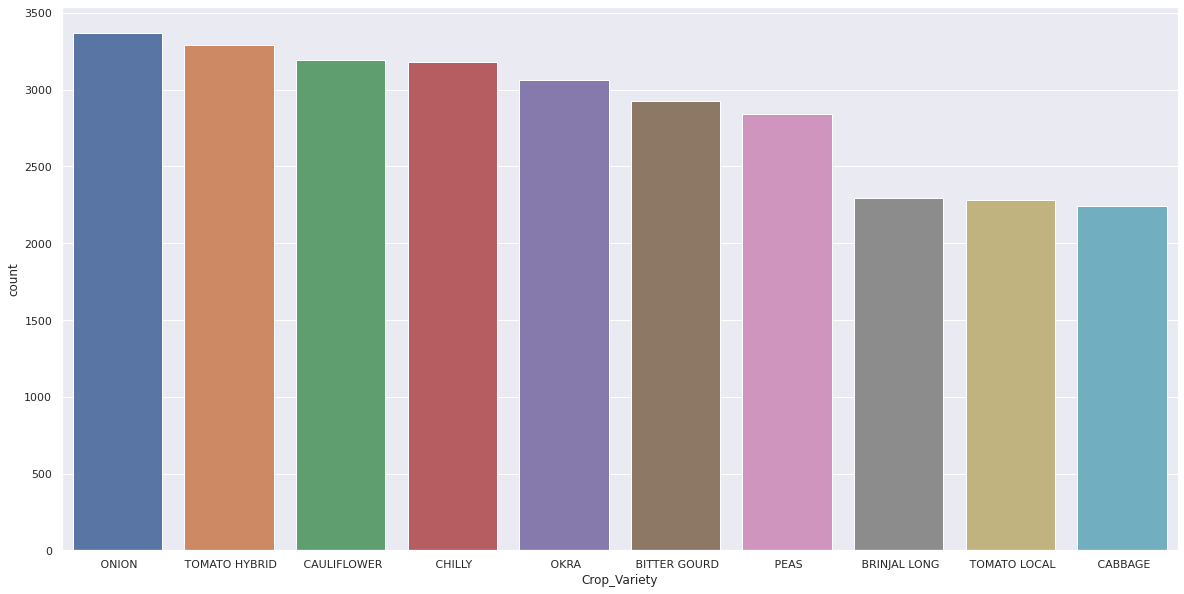

In [143]:
sns.set(rc={"figure.figsize":(20, 10)})
sns.countplot(data=df_final1, x='Crop_Variety', order=df_final1.Crop_Variety.value_counts().index)
plt.savefig('save_as_a_png.png')
#files.download("save_as_a_png.png") 

In [144]:
df_vis =pd.DataFrame()
df_final1[['Crop_Variety','Year','Std_Price']].groupby(['Crop_Variety','Year']).mean()

Std_Price
Crop_Variety  Year           
 BITTER GOURD 2011  32.943086
              2012  34.052499
              2013  37.840632
              2014  37.264114
              2015  37.107535
...                       ...
 TOMATO LOCAL 2016  22.100153
              2017  25.643279
              2018  19.536327
              2019  23.883158
              2020  22.079388

[97 rows x 1 columns]

In [145]:
x= df_final1[['Crop_Variety','Year','Std_Price']].groupby(['Crop_Variety','Year']).mean().reset_index()

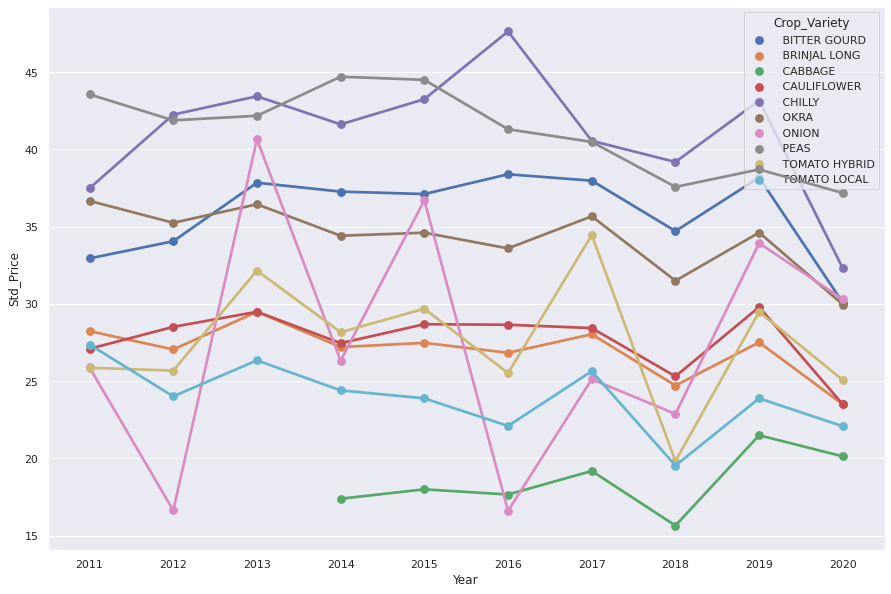

In [146]:
sns.set(rc={"figure.figsize":(15, 10)})
sns.pointplot(x="Year", y="Std_Price", hue='Crop_Variety', data=x)
plt.savefig('save_as_a_png5.png')
#files.download("save_as_a_png5.png") 

In [147]:
 df_final1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28680 entries, 0 to 28679
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                28680 non-null  int64  
 1   Month               28680 non-null  object 
 2   ALLSKY_SFC_PAR_TOT  28680 non-null  object 
 3   CLOUD_AMT           28680 non-null  object 
 4   GWETPROF            28680 non-null  object 
 5   GWETROOT            28680 non-null  object 
 6   GWETTOP             28680 non-null  object 
 7   PRECTOTCORR         28680 non-null  object 
 8   QV2M                28680 non-null  object 
 9   T2MDEW              28680 non-null  object 
 10  T2M_MAX             28680 non-null  object 
 11  T2M_MIN             28680 non-null  object 
 12  WS2M_MAX            28680 non-null  object 
 13  WS2M_MIN            28680 non-null  object 
 14  State               28680 non-null  object 
 15  Crop_Variety        28680 non-null  object 
 16  Std_

In [148]:
df_final = spark.createDataFrame(df_final1)

In [149]:
df_final1.rename(columns = {'Crop_Variety':'Crop'}, inplace = True)

In [150]:
#df_final1.to_csv(r'/content/drive/MyDrive/Capstone/Datasets/Final_Datasets/Final_Dataset.csv', index = False) # Downloading final cleansed and merged dataset as final_Dataset in excel format.

In [151]:
df1 = df_final1
list_crops = df1.Crop.unique()

In [152]:
list_crops

array([' BITTER GOURD', ' BRINJAL LONG', ' CAULIFLOWER', ' CHILLY',
       ' OKRA', ' ONION', ' PEAS', ' TOMATO HYBRID', ' TOMATO LOCAL',
       ' CABBAGE'], dtype=object)

In [153]:
df1["Std_Price"] = df1.Std_Price.astype(float)


In [154]:
df_final = df1.drop(columns =['Year','Month',"State"],axis = 1)

In [155]:
df_final.head(10)

,ALLSKY_SFC_PAR_TOT,CLOUD_AMT,GWETPROF,GWETROOT,GWETTOP,PRECTOTCORR,QV2M,T2MDEW,T2M_MAX,T2M_MIN,WS2M_MAX,WS2M_MIN,Crop,Std_Price
0,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,BITTER GOURD,27.052336
1,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,BRINJAL LONG,33.630925
2,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,CAULIFLOWER,19.898545
3,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,CHILLY,27.140382
4,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,OKRA,33.941987
5,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,ONION,63.283535
6,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,PEAS,33.630925
7,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,TOMATO HYBRID,30.486155
8,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,TOMATO LOCAL,33.017497
9,60.62,39.52,0.68,0.66,0.66,0.48,7.81,10.05,24.02,7.31,0.91,0.02,BITTER GOURD,33.630925


In [156]:
list_crops

array([' BITTER GOURD', ' BRINJAL LONG', ' CAULIFLOWER', ' CHILLY',
       ' OKRA', ' ONION', ' PEAS', ' TOMATO HYBRID', ' TOMATO LOCAL',
       ' CABBAGE'], dtype=object)

In [157]:
df_final = df1.drop(columns =['Year','Month'],axis = 1)

In [158]:
df_final = df_final.drop(["State"],axis = 1)

In [159]:
df_final

,ALLSKY_SFC_PAR_TOT,CLOUD_AMT,GWETPROF,GWETROOT,GWETTOP,PRECTOTCORR,QV2M,T2MDEW,T2M_MAX,T2M_MIN,WS2M_MAX,WS2M_MIN,Crop,Std_Price
0,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,BITTER GOURD,27.052336
1,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,BRINJAL LONG,33.630925
2,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,CAULIFLOWER,19.898545
3,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,CHILLY,27.140382
4,93.48,29.55,0.68,0.69,0.68,0.01,13.24,18.41,29.9,14.91,5.29,0.2,OKRA,33.941987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28675,58.88,20.76,0.6,0.61,0.64,0,9.09,12.46,26.4,6.3,3.31,0.07,OKRA,45.495102
28676,58.88,20.76,0.6,0.61,0.64,0,9.09,12.46,26.4,6.3,3.31,0.07,ONION,46.296359
28677,58.88,20.76,0.6,0.61,0.64,0,9.09,12.46,26.4,6.3,3.31,0.07,PEAS,57.215184
28678,58.88,20.76,0.6,0.61,0.64,0,9.09,12.46,26.4,6.3,3.31,0.07,TOMATO HYBRID,36.857823


In [160]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(df_final[['Crop']]).toarray())
# merge with main df bridge_df on key values
df_final = df_final.join(enc_df)

In [161]:
df_final1 = df_final.drop(["Crop","Std_Price"],axis = 1)
X = df_final1.values
y = df_final["Std_Price"].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)



sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

input_layer = Input(shape=(X.shape[1],))
dense_layer_1 = Dense(100, activation='relu')(input_layer)
dense_layer_2 = Dense(50, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(25, activation='relu')(dense_layer_2)
output = Dense(1)(dense_layer_3)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history = model.fit(X_train, y_train, batch_size=1, epochs=20, verbose=1, validation_split=0.2)


pred_train = model.predict(X_train)
print(np.sqrt(np.sqrt(mean_squared_error(y_train,pred_train))))
#list1.append(np.sqrt(np.sqrt(mean_squared_error(y_train,pred_train))))
pred = model.predict(X_test)
print(np.sqrt(np.sqrt(mean_squared_error(y_test,pred))))

Epoch 1/20
18355/18355 [==============================] - 39s 2ms/step - loss: 279.9578 - mean_squared_error: 279.9578 - val_loss: 251.9751 - val_mean_squared_error: 251.9751
Epoch 2/20
18355/18355 [==============================] - 37s 2ms/step - loss: 259.7217 - mean_squared_error: 259.7217 - val_loss: 243.2158 - val_mean_squared_error: 243.2158
Epoch 3/20
18355/18355 [==============================] - 37s 2ms/step - loss: 252.1628 - mean_squared_error: 252.1628 - val_loss: 232.1288 - val_mean_squared_error: 232.1288
Epoch 4/20
18355/18355 [==============================] - 42s 2ms/step - loss: 244.9198 - mean_squared_error: 244.9198 - val_loss: 255.8232 - val_mean_squared_error: 255.8232
Epoch 5/20
18355/18355 [==============================] - 39s 2ms/step - loss: 239.2099 - mean_squared_error: 239.2099 - val_loss: 232.5649 - val_mean_squared_error: 232.5649
Epoch 6/20
18355/18355 [==============================] - 38s 2ms/step - loss: 235.8512 - mean_squared_error: 235.8512 - val_